## <strong style="color:RoyalBlue">Introduction</strong>

* The dataset has 14249 observations for past/present employees.
* The observations span 12 different departments.
* Each observation includes the employee’s current employment status.

### Features

Target variable
* 'status' – Current employment status (Employed / Left)

Administrative information
* 'department' – Department employees belong(ed) to
* 'salary' – Salary level relative to rest of their department
* 'tenure' – Number of years at the company
* 'recently_promoted' – Was the employee promoted in the last 3 years?

Workload information
* 'n_projects' – Number of projects employee is staffed on
* 'avg_monthly_hrs' – Average number of hours worked per month

Mutual evaluation information
* 'satisfaction' – Score for employee’s satisfaction with the company (higher is better)
* 'last_evaluation' – Score for most recent evaluation of employee (higher is better)
* 'filed_complaint' – Has the employee filed a formal complaint in the last 3 years?

There is no definite goal here. Goal is to have maximum employees stay with the company.

## <strong style="color:RoyalBlue">Library Imports</strong>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Import XGBClassifier
from xgboost import XGBClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

In [3]:
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
sns.set_style('darkgrid')
pd.options.display.max_columns=100

In [5]:
df = pd.read_csv('employee_data.csv')
df.shape

(14249, 10)

## <strong style="color:RoyalBlue">Exploratory Analysis</strong>

In [6]:
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [7]:
df.dtypes

avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object

In [8]:
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000000,2058.0,12717.000000,14249.000000,300.0,14068.000000,14068.000000
mean,199.795775,1.0,0.718477,3.773809,1.0,0.621295,3.497228
std,50.998714,0.0,0.173062,1.253126,0.0,0.250469,1.460917
min,49.000000,1.0,0.316175,1.000000,1.0,0.040058,2.000000
25%,155.000000,1.0,0.563866,3.000000,1.0,0.450390,3.000000
50%,199.000000,1.0,0.724939,4.000000,1.0,0.652527,3.000000
75%,245.000000,1.0,0.871358,5.000000,1.0,0.824951,4.000000
max,310.000000,1.0,1.000000,7.000000,1.0,1.000000,10.000000


In [9]:
# Let's see the summary statistics for categorical features
df.select_dtypes(include='object').describe()

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


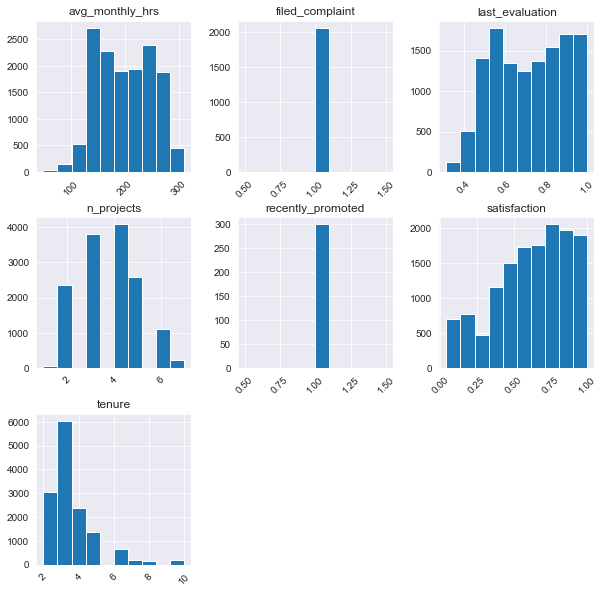

In [10]:
df.hist(figsize=(10,10), xrot=45)
plt.show()

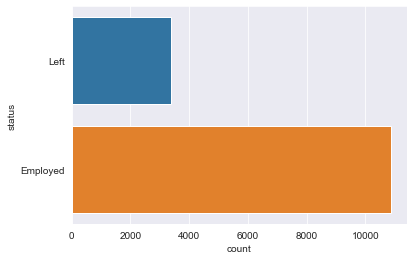

In [11]:
sns.countplot(y=df.status)
plt.show()

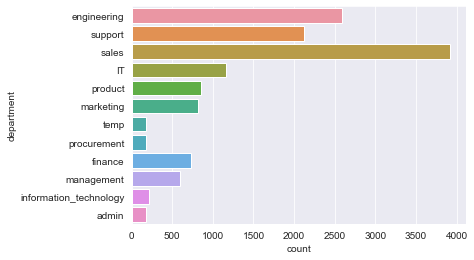

In [12]:
sns.countplot(y=df.department)
plt.show()

IT and information_technology are the same. Let's keep note of it and combine them during Data Cleaning step.

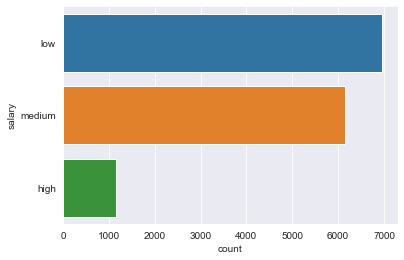

In [13]:
sns.countplot(y=df.salary)
plt.show()

We can make salary Numerical by assigning 0, 1 and 2 for low, medium and high respectively. Let's take a note and do it in Feature Engineering step.

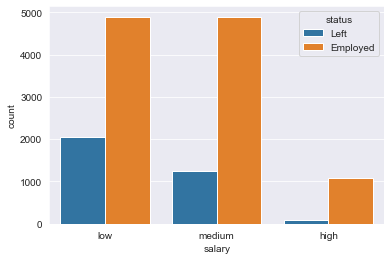

In [14]:
# Let's see salary by status.
sns.countplot(df.salary, hue=df.status)
plt.show()

Looks like high salary people are less to leave.

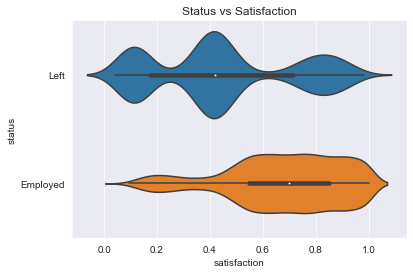

In [15]:
# let's see violin plot of 'status' vs 'satisfaction'
sns.violinplot(df.satisfaction, df.status)
plt.title('Status vs Satisfaction')
plt.show()

It is obvious from the graph that less satisfied people are more likely to leave.

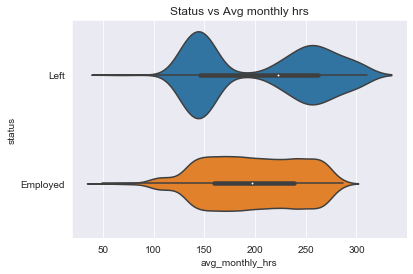

In [16]:
# let's see violin plot of 'status' vs 'avg_monthly_hrs'
sns.violinplot(y=df.status, x=df.avg_monthly_hrs)
plt.title('Status vs Avg monthly hrs')
plt.show()

It clearly shows that people with avg_monthly_hrs of around 150 and around 250 are more likely to leave.

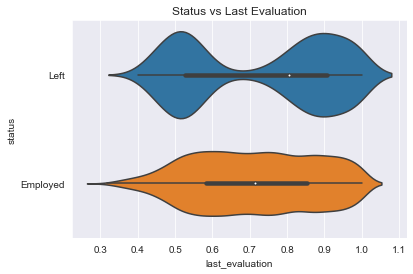

In [17]:
# Let's see violin plot of 'status' vs 'last_evaluation'
sns.violinplot(y=df.status, x=df.last_evaluation)
plt.title('Status vs Last Evaluation')
plt.show()

It shows that people with average evaluation are more likely to stay compared to those with low and high evalution

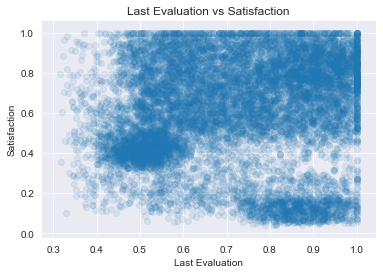

In [18]:
plt.scatter(df.last_evaluation, df.satisfaction, alpha=.1)
plt.xlabel('Last Evaluation')
plt.ylabel('Satisfaction')
plt.title('Last Evaluation vs Satisfaction')
plt.show()

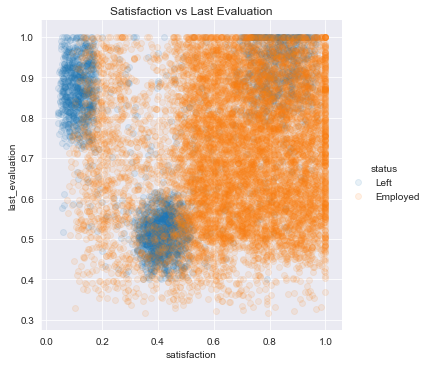

In [19]:
# Scatterplot of satisfaction vs. last_evaluation segmented by status
sns.lmplot(y='last_evaluation', 
           x='satisfaction', 
           data=df, 
           hue='status', fit_reg=False, scatter_kws={'alpha':.1})
plt.title('Satisfaction vs Last Evaluation')
plt.show()

Let's see only those who left. Looks like there is some pattern.

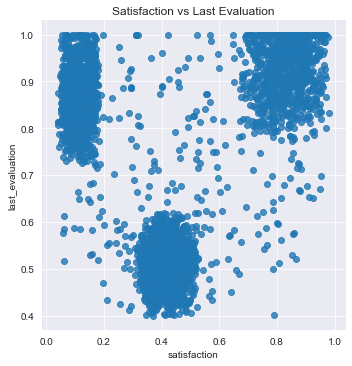

In [20]:
sns.lmplot(x='satisfaction',
           y='last_evaluation',
           data=df[df.status == 'Left'],
           fit_reg=False)
plt.title('Satisfaction vs Last Evaluation')
plt.show()

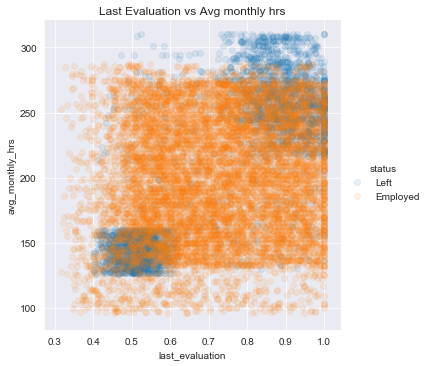

In [21]:
sns.lmplot(x='last_evaluation', 
           y='avg_monthly_hrs', 
           hue='status', 
           data=df, 
           fit_reg=False,
           scatter_kws={'alpha': 0.1})
plt.title('Last Evaluation vs Avg monthly hrs')
plt.show()

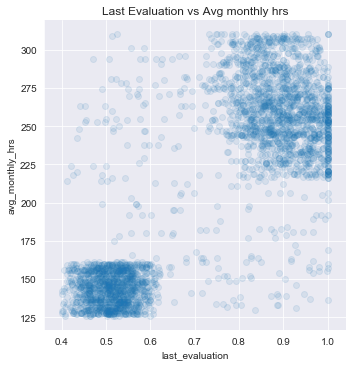

In [22]:
sns.lmplot(x='last_evaluation',
           y='avg_monthly_hrs',
           data=df[ df.status == 'Left'],
           fit_reg=False,
           scatter_kws={'alpha':0.1})
plt.title('Last Evaluation vs Avg monthly hrs')
plt.show()

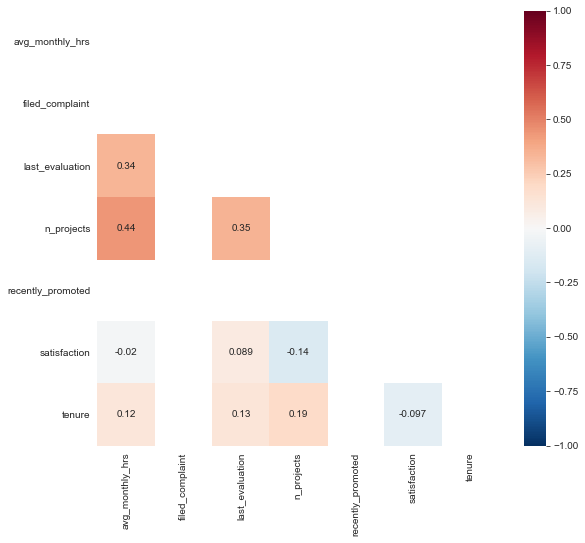

In [23]:
df_corr = df.corr()
sns.set_style('whitegrid')

bool_mask = np.zeros_like(df_corr)
bool_mask[np.triu_indices_from(df_corr)]=1

plt.figure(figsize=(9,8))
sns.heatmap(df_corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, mask=bool_mask)
plt.show()

Looks like we need to fill missing values in 'filed_compaint' and 'recently_promoted' to see clear correlation

In [24]:
df.filed_complaint.unique()

array([nan,  1.])

In [25]:
df.filed_complaint.fillna(0, inplace=True)

In [26]:
df.recently_promoted.unique()

array([nan,  1.])

In [27]:
df.recently_promoted.fillna(0, inplace=True)

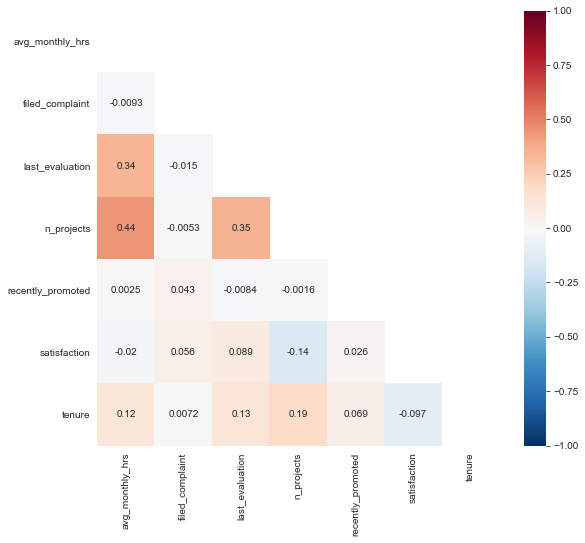

In [28]:
df_corr1 = df.corr()
sns.set_style('whitegrid')

bool_mask1 = np.zeros_like(df_corr1)
bool_mask1[np.triu_indices_from(df_corr1)]=1

plt.figure(figsize=(9,8))
sns.heatmap(df_corr1, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, mask=bool_mask1)
plt.show()

## <strong style="color:RoyalBlue">Data Cleaning</strong>

In [29]:
# Are there still missing values?
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1532
n_projects              0
recently_promoted       0
salary                  0
satisfaction          181
status                  0
tenure                181
dtype: int64

In [30]:
df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

In [31]:
# Let's label missing values in 'department' as 'Missing'
df.department.fillna('Missing', inplace=True)

In [32]:
# Let's replace all instances of the 'information_technology' with 'IT'
df.department.replace('information_technology', 'IT', inplace=True)

In [33]:
# Let's remove records with the department 'temp'. Our model is only for permanent, full time employees.
df = df[ df.department != 'temp']

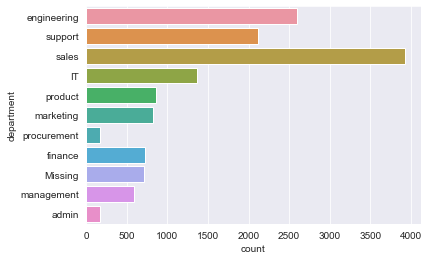

In [34]:
sns.set_style('darkgrid')
sns.countplot(y=df.department)
plt.show()

In [35]:
# let's flag 'last_evaluation' with an indicator variable of missingness
df['last_evaluation_missing'] = df.last_evaluation.isnull().astype(int)

In [36]:
# Now, simply fill in the original missing value with 0
df.last_evaluation.fillna(0, inplace=True)

In [37]:
# Now there should not be missing values
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

In [38]:
# Are there any duplicates?
df.duplicated().sum()

0

## <strong style="color:RoyalBlue">Feature Engineering</strong>

In [39]:
df.salary.unique()

array(['low', 'medium', 'high'], dtype=object)

Let's make salary Numeric and see its correlation with other features.

In [40]:
df['salary_numeric'] = df.salary.replace({'low': 0, 'medium': 1, 'high': 2})

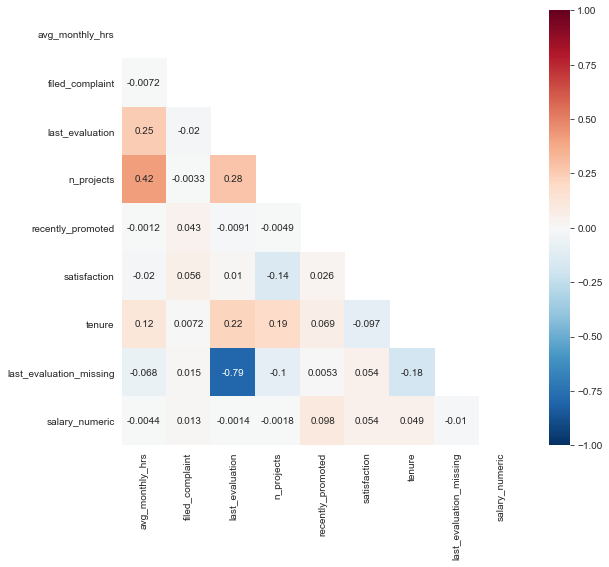

In [41]:
df_corr2 = df.corr()
sns.set_style('whitegrid')

bool_mask2 = np.zeros_like(df_corr2)
bool_mask2[np.triu_indices_from(df_corr2)]=1

plt.figure(figsize=(9,8))
sns.heatmap(df_corr2, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, mask=bool_mask2)
plt.show()

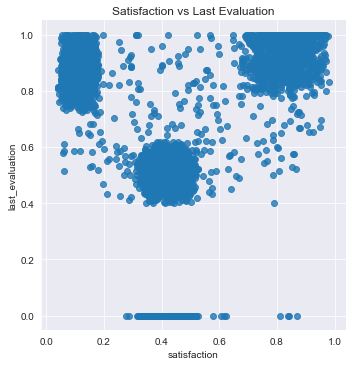

In [42]:
# scatterplot of 'satisfaction' vs 'last_evaluation' for employees who have 'Left'
sns.set_style('darkgrid')
sns.lmplot(x='satisfaction',
           y='last_evaluation',
           data=df[df.status == 'Left'],
           fit_reg=False)
plt.title('Satisfaction vs Last Evaluation')
plt.show()

There are 3 clusters.

1. First, we have people with high 'last_evaluation' but low 'satisfaction'. Maybe these people were overqualified, frustrated, or unhappy in some other way.
2. Next, we have people with low 'last_evaluation' and medium 'satisfaction'. These were probably underperformers or poor cultural fits.
3. Finally, we have people with high 'last_evaluation' and high 'satisfaction'. Perhaps these were overachievers who found better offers elsewhere.

These roughly translate to 3 indicator features we can engineer:

* 'unhappy' - satisfaction_level < 0.2
* 'underperformer' - last_evaluation < 0.6 and last_evaluation_missing == 0
* 'overachiever' - last_evaluation > 0.8 and satisfaction > 0.7

For 'underperformer', it's important to include 'last_evaluation_missing' == 0 to avoid those originally missing observations that we flagged and filled.

In [43]:
df['unhappy'] = (df.satisfaction < 0.2).astype(int)
df['underperformer'] = ((df.last_evaluation < 0.6) & (df.last_evaluation_missing == 0)).astype(int)
df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

Let's see the proportion of employees from the dataset that fall into each of those 3 categories.

In [44]:
df[['underperformer','unhappy','overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

Let's convert target variable 'status' into an indicator variable.
* 'Left' should be 1
* 'Employed' should be 0

In [45]:
df['status'] = pd.get_dummies(df.status).Left
df.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,last_evaluation_missing,salary_numeric,unhappy,underperformer,overachiever
0,221,engineering,0.0,0.932868,4,0.0,low,0.829896,1,5.0,0,0,0,0,1
1,232,support,0.0,0.000000,3,0.0,low,0.834544,0,2.0,1,0,0,0,0
2,184,sales,0.0,0.788830,3,0.0,medium,0.834988,0,3.0,0,1,0,0,0
3,206,sales,0.0,0.575688,4,0.0,low,0.424764,0,2.0,0,0,0,1,0
4,249,sales,0.0,0.845217,3,0.0,low,0.779043,0,3.0,0,0,0,0,1


In [46]:
abt_df = pd.get_dummies(df, columns=df.columns[df.dtypes=='object'])
abt_df.shape

(14068, 27)

## <strong style="color:RoyalBlue">Model Training</strong>

### Data Spending

In [47]:
X = abt_df.drop('status', axis=1)
y = abt_df.status

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1234, 
                                                    stratify=abt_df.status)

print(X_train.shape, X_test.shape)

(11254, 26) (2814, 26)


### Pre-Processing & Pipelines

In [49]:
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(random_state=123, 
                                                             penalty='l1',
                                                             solver='liblinear')),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(random_state=123, 
                                                             penalty='l2')),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123)),
    'enet': make_pipeline(StandardScaler(), LogisticRegression(random_state=123,
                                                               penalty='elasticnet',
                                                               solver='saga')),
    'xgb': make_pipeline(StandardScaler(), XGBClassifier(random_state=123))
}

In [50]:
# pipelines['xgb'].get_params()

### Hyperparameter Tuning

In [51]:
l1_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

enet_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
    'logisticregression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10],
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

xgb_hyperparameters = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],
    'xgbclassifier__max_depth': [1, 3, 5]    
}

In [52]:
hyperparameters = {
    'l1': l1_hyperparameters,
    'l2': l2_hyperparameters,
    'enet': enet_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters,
    'xgb': xgb_hyperparameters
}

## <strong style="color:RoyalBlue">Algorithm Selection</strong>

In [53]:
import time

fitted_models = {}

for key in pipelines.keys():
    start = time.time()
    model = GridSearchCV(pipelines[key], hyperparameters[key], cv=10, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    fitted_models[key] = model
    end = time.time()
    
    print('{} has been fitted. Took {} seconds'.format(key, end-start))

l1 has been fitted. Took 81.43171620368958 seconds
l2 has been fitted. Took 13.477465867996216 seconds
rf has been fitted. Took 918.7924830913544 seconds
gb has been fitted. Took 817.6809351444244 seconds
enet has been fitted. Took 461.2365925312042 seconds
xgb has been fitted. Took 972.4781124591827 seconds


### Winner Model

In [54]:
for name,model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    auroc = roc_auc_score(y_test, pred)
    
    print(name, auroc)

l1 0.9015409194159456
l2 0.9015402254018862
rf 0.9917231883283493
gb 0.9885976960121259
enet 0.9015430014581235
xgb 0.9892906690503737


In [55]:
fitted_models['rf'].best_params_

{'randomforestclassifier__max_features': 0.33,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 200}

In [56]:
fitted_models['rf'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.33,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=Fals

In [59]:
pred = fitted_models['rf'].predict_proba(X_train)

In [60]:
pred

array([[0.32 , 0.68 ],
       [0.035, 0.965],
       [0.   , 1.   ],
       ...,
       [1.   , 0.   ],
       [0.965, 0.035],
       [1.   , 0.   ]])

In [61]:
pred = [p[1] for p in pred]

# Calculate ROC curve from y and pred
fpr, tpr, threshold = roc_curve(y_train, pred)

In [62]:
pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':np.round(threshold,6)})

,FPR,TPR,Threshold
0,0.000000,0.000000,2.000
1,0.000000,0.541574,1.000
2,0.000000,0.662955,0.995
3,0.000000,0.727543,0.990
4,0.000000,0.769859,0.985
...,...,...,...
121,0.175584,1.000000,0.020
122,0.228271,1.000000,0.015
123,0.320093,1.000000,0.010
124,0.484579,1.000000,0.005


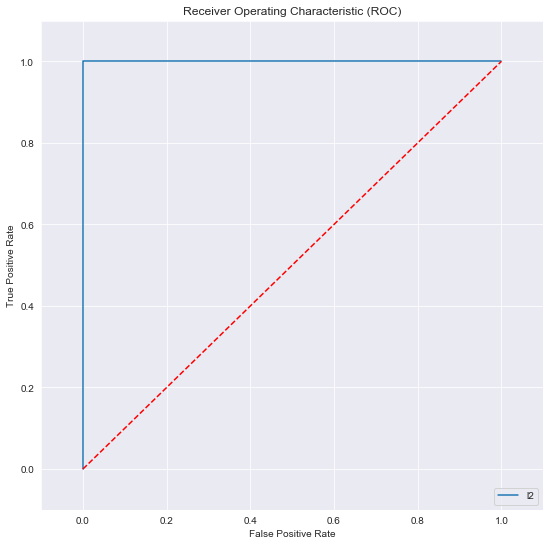

In [63]:
# Initialize figure
plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic (ROC)')

# Plot ROC curve
plt.plot(fpr, tpr, label='l2')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1], [0,1], 'r--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)